# Gap Tuning for the Elevator
This Jupyter Notebook plots the fidelity metrics for the (4-0-4) elevator scenario and performs a change point analysis and linear regression on the input data to analyze the influence and statistical significance of the MAD, opening, and extending gap parameters on the fidelity metrics (% matched snapshots, Fréchet distance, Euclidean distance).

It takes the information stored in /resources/output/lift/gap_tuning from previously performed alignments and performs the corresponding computations.

## Imports and constants

In [3]:
import os

import matplotlib.pyplot as plt
import ruptures as rpt
import pandas as pd
from util import generate_sublist

from result_analysis import get_change_point
from result_analysis.gap_tunning import execute_regression

from IPython.display import Markdown, HTML

current_directory = os.path.abspath(os.path.join(os.getcwd(), '../../'))
output_directory = current_directory + '/resources/output/lift/gap_tuning/'

files = ['Bajada_4_0_4Bajada_4_0_4_01.csv']

param_interest = 'accel(m/s2)'

params = [f'mad_{param_interest}',
          'init_gap',
          'cont_gap',
          'percentage_matched_snapshots',
          'frechet_euclidean',
          'p2p_mean_euclidean',
          'number_of_gaps',
          'mean_length_gaps_mean']

params_labels = [f'MAD temp (ºC)',
                 'Penalty Opening Gap',
                 'Penalty Extending Gap',
                 '%matched snapshots',
                 'Frèchet euclidean',
                 'Euclidean Avg',
                 'Number of gaps',
                 'Avg length of gaps']

# It orders first by %matched snapshots and then by number of gaps, to visually analyse their influence over other parameters
ordering_params = [3, 6]
# In the first graphic, we include the fidelity metrics and in the second, the gap statistics
include_params = [[(0, 5)], [(0, 3), (6, 7)]]
filters = {
            'affine': ['init_gap', lambda x: x < 0.0],
            'simple' : ['init_gap', lambda x: x == 0.0],
           }
assert(len(ordering_params) == len(include_params))

text_content = ''

## Change point analysis and linear regression

# Scenario (4-0-4)


## Affine Gap


### Ordered by %matched snapshots


PlotlyError: The `figure_or_data` positional argument must be `dict`-like, `list`-like, or an instance of plotly.graph_objs.Figure

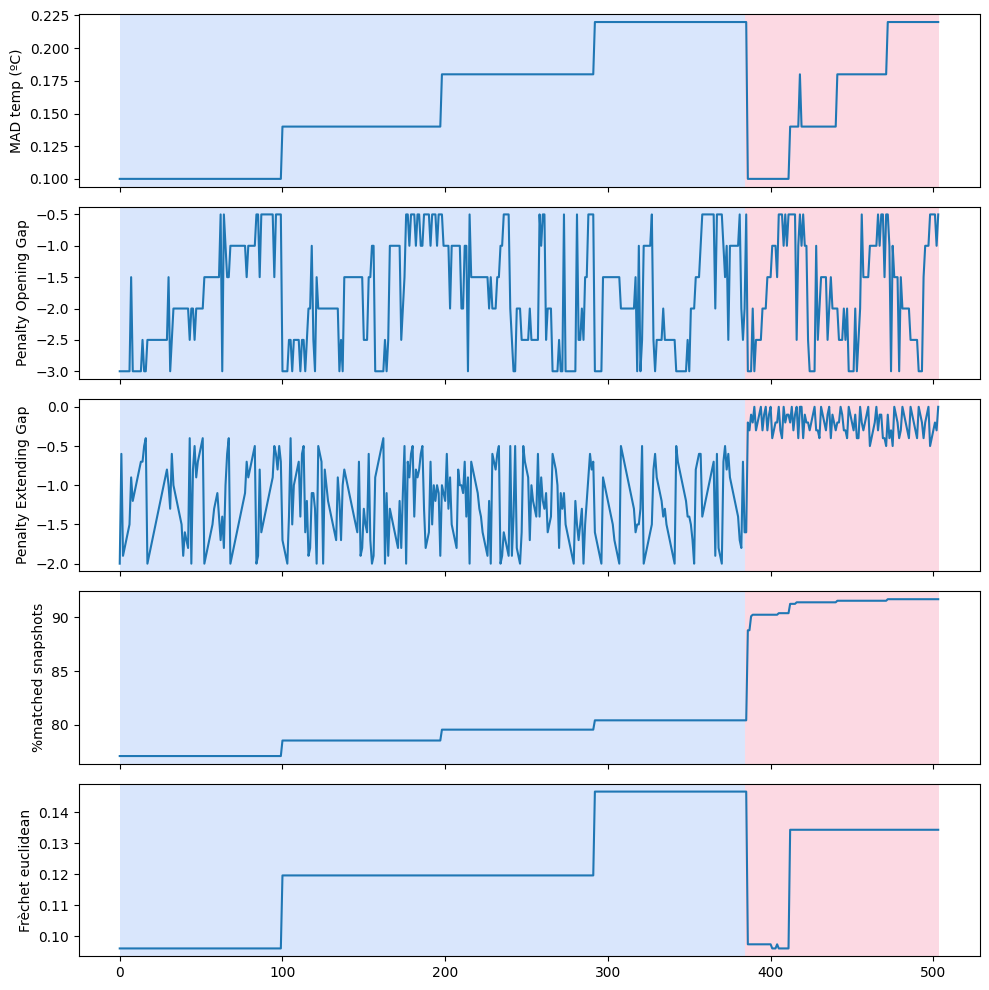

In [4]:
for file in files:
    display(Markdown(f'# Scenario (4-0-4)\n'))
    df = pd.read_csv(f'{output_directory}{file}')
    for gap_type, values in filters.items():
        display(Markdown(f'## {gap_type.capitalize()} Gap\n'))
        # Filter the values to perform the analysis of the affine or the simple gap
        filtered_df = df[values[1](df[values[0]])]
        for index, ordering_param in enumerate(ordering_params):
            display(Markdown(f'### Ordered by {params_labels[ordering_param]}\n'))
            selected_params = generate_sublist(params, include_params[index])
            selected_label_params = generate_sublist(params_labels, include_params[index])

            # It performs the change point analysis: Given a segment model, it computes the best partition
            signals, result = get_change_point(filtered_df,
                                               [selected_params[0], params[ordering_param]],
                                               selected_params, number_of_changes=1)
            _, axs = rpt.display(signals, result)

            for i, label in enumerate(selected_label_params):
                axs[i].set_ylabel(label)

            plt.tight_layout()
            plt.savefig(f'{output_directory}/output_{gap_type}_a_{os.path.splitext(file)[0]}.pdf', format='pdf')
            plt.show()

        display(Markdown(f'### Regression analysis all samples\n'))
        display(HTML(execute_regression(filtered_df, 0, param_interest).summary().as_html()))
        display(Markdown(f'### Regression analysis segment\n'))
        # After performing the change point analysis, 87% is the percentage in which the change point is detected.
        display(HTML(execute_regression(filtered_df, 87, param_interest).summary().as_html()))